In [1]:
#imports

import h5py
import matplotlib.pyplot as plt
import numpy as np
import skimage.measure  
from skimage.metrics import mean_squared_error 
import seaborn as sns
import pandas as pd
import scipy.ndimage.interpolation as interp
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from sklearn import linear_model

In [2]:
#functions 

#downsamples image to specified size using specified method
def downsampleIMG(img1, size, method):
    size1 = int(img1.shape[0])
    size2 = size

    factor = int(size1/size2)

    if (method == 'max'):
        img1_reduced = skimage.measure.block_reduce(img1, (factor,factor), np.max)
    
    if (method == 'mean'):
        img1_reduced = skimage.measure.block_reduce(img1, (factor,factor), np.mean)

    print(f'The new size of the image is {img1_reduced.shape}')

    return img1_reduced

#upsamples image to specified size using specified method (we used "nearest" for nearest neighbors )
def upsampleIMG(img, size, pickMode):
    factor = size / img.shape[0]
    newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)
    print(f'The new size of the image is {newImg.shape}')
    return newImg

#normalizes a property between 0 and 1 
def min_max_norm(X):
    
    return (X - np.nanmin(X)) / (np.nanmax(X) - np.nanmin(X))

In [4]:
#reading in the data 
pressure = h5py.File('Data/pressure.mat')
pressure.keys()

<KeysViewHDF5 ['pressure03MAR', 'pressure04JAN', 'pressure04JUL', 'pressure04MAR', 'pressure04MAY', 'pressure04SEP', 'pressure05JAN', 'pressure05JUL', 'pressure05MAR', 'pressure05MAY', 'pressure05SEP', 'pressure06JAN', 'pressure06JUL', 'pressure06MAY', 'pressure06SEP']>

In [46]:
# function 


def testDay(dataset):
#returns a 500,000 sample of pixels in specified dataset. Columns include COD,CTT,Pressure, SZA,LZA,ln(cod), ln(cod)*sza, lat, lon, TCM.    
    
    data = h5py.File(f'Data/{dataset}', 'r')
    pressData = h5py.File('Data/pressure.mat')
    
    print(data.keys())
    
    
    cod = np.transpose(data['cod'][()])
    ctt = np.transpose(data['ctt'][()])
    sza = data['sza'][()]
    tcm = data['TCM'][()]
    lza = data['lza'][()]
    
    if dataset == "04JAN2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure04JAN'][()])
    elif dataset == "05JAN2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure05JAN'][()])
    elif dataset == "06JAN2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure06JAN'][()])
    elif dataset == "04MAR2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure04MAR'][()])
    elif dataset == "05MAR2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure05MAR'][()])
    elif dataset == "03MAR2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure03MAR'][()])
    elif dataset == "04JULY2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure04JUL'][()])
    elif dataset == "05JULY2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure05JUL'][()])
    elif dataset == "06JULY2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure06JUL'][()])
    elif dataset == "04MAY2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure04MAY'][()])
    elif dataset == "05MAY2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure05MAY'][()])    
    elif dataset == "06MAY2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure06MAY'][()])
    elif dataset == "04SEP2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure04SEP'][()])
    elif dataset == "05SEP2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure05SEP'][()])
    elif dataset == "06SEP2020.mat":
        print(dataset[0:4])
        pressure = np.transpose(pressData['pressure06SEP'][()])
    
    
    print("Variables read in correctly")
    
    #downsampling and upsampling 
    size = 10848

    #downsamples
    sza_ds = downsampleIMG(sza, size, 'max')
    tcm_ds = downsampleIMG(tcm, size, 'max')
    lza_ds = downsampleIMG(lza, size, 'max')

    #upsamples 
    cod_us = upsampleIMG(cod, size, 'nearest')
    ctt_us = upsampleIMG(ctt, size, 'nearest')
    pressure_us = upsampleIMG(pressure, size, 'nearest')
    
    print("variables correctly sized")
    
    #normalize the variables now 

    cod_n = min_max_norm(cod_us)
    ctt_n = min_max_norm(ctt_us)
    sza_n = min_max_norm(sza_ds)
    lza_n = min_max_norm(lza_ds)
    tcm_n = min_max_norm(tcm_ds)
    press_n = min_max_norm(pressure_us)

    
    print("Variables correctly normalized")
    
    codStretch = cod_n.reshape(-1)
    cttStretch = ctt_n.reshape(-1)
    szaStretch = sza_n.reshape(-1)
    lzaStretch = lza_n.reshape(-1)
    tcmStretch = tcm_n.reshape(-1)
    pressStretch = press_n.reshape(-1)
    
    df = pd.DataFrame()
    
    df['cod'] = codStretch.tolist()
    df['ctt'] = cttStretch.tolist()
    df['sza'] = szaStretch.tolist()
    df['lza'] = lzaStretch.tolist()
    df['tcm'] = tcmStretch.tolist()
    df['pressure'] = pressStretch.tolist()
    
    print("DataFrame correctly made")
    
    #transformations 
    df_ds = df.dropna()
    print(df_ds)
    print("Shape of dataframe is ", df_ds.shape)
    print("NaN's dropped")
    
    latlon = scipy.io.loadmat('Data/latlon.mat')
    lat = latlon['latPool']
    lon = latlon['lonPool']
    
    latScaler = MinMaxScaler(feature_range=(-1, 1))
    lonScaler = MinMaxScaler(feature_range=(-1, 0))

    lat_s = latScaler.fit_transform(lat)
    lon_s = lonScaler.fit_transform(lon)
    
    print("Latitude and Longitude normalized")
    
    lat_s = lat_s.reshape(-1)
    lon_s = lon_s.reshape(-1)

    df_latlon = pd.DataFrame()

    df_latlon['lat'] = lat_s.tolist()
    df_latlon['lon'] = lon_s.tolist()

    df_merge = df_ds.merge(df_latlon, how = "left", left_index = True, right_index = True)
    
    print("Dataset merged")
    
    df_merge['lncod'] = np.log(df_merge[['cod']])
    
    df_merge["lncodSza"] = df_merge["lncod"]*df_merge["sza"]
    print(f'Shape of dataset is: {df_merge.shape}')
    
    df_date = df_merge.sample(n=500000, random_state = 42)
    
    #return df_date, predictions
    return df_date
    #return df_merge
    
    
    
def testDayNS(dataset):
#returns dataframe of specified dataset (day), returns all records that do not include unrecorded data, includes all properties except CTT when commented (can include CTT if uncommented)   
    
    data = h5py.File(f'Data/{dataset}', 'r')
    
    print(data.keys())

    cod = np.transpose(data['cod'][()])
    #commenting out ctt for model3
    #ctt = np.transpose(data['ctt'][()])
    sza = data['sza'][()]
    tcm = data['TCM'][()]
    lza = data['lza'][()]
    
    #print(cod)
    #print(tcm)
    
    print("Variables read in correctly")
    
    #downsampling and upsampling 
    size = 10848

    #downsamples
    sza_ds = downsampleIMG(sza, size, 'max')
    tcm_ds = downsampleIMG(tcm, size, 'max')
    lza_ds = downsampleIMG(lza, size, 'max')

    #upsamples 
    cod_us = upsampleIMG(cod, size, 'nearest')
    #ctt_us = upsampleIMG(ctt, size, 'nearest')
    
    print("variables correctly sized")
    
    #normalize the variables now 

    cod_n = min_max_norm(cod_us)
    #ctt_n = min_max_norm(ctt_us)
    sza_n = min_max_norm(sza_ds)
    lza_n = min_max_norm(lza_ds)
    tcm_n = min_max_norm(tcm_ds)
    
    print("Variables correctly normalized")
    
    codStretch = cod_n.reshape(-1)
    #cttStretch = ctt_n.reshape(-1)
    szaStretch = sza_n.reshape(-1)
    lzaStretch = lza_n.reshape(-1)
    tcmStretch = tcm_n.reshape(-1)
    
    df = pd.DataFrame()
    
    df['cod'] = codStretch.tolist()
    #df['ctt'] = cttStretch.tolist()
    df['sza'] = szaStretch.tolist()
    df['lza'] = lzaStretch.tolist()
    df['tcm'] = tcmStretch.tolist()
    
    print("DataFrame correctly made")
    
    #transformations 
    df_ds = df.dropna()
    print(df_ds)
    print("Shape of dataframe is ", df_ds.shape)
    print("NaN's dropped")
    
    latlon = scipy.io.loadmat('Data/latlon.mat')
    lat = latlon['latPool']
    lon = latlon['lonPool']
    
    latScaler = MinMaxScaler(feature_range=(-1, 1))
    lonScaler = MinMaxScaler(feature_range=(-1, 0)) 

    lat_s = latScaler.fit_transform(lat)
    lon_s = lonScaler.fit_transform(lon)
    
    print("Latitude and Longitude normalized")
    
    lat_s = lat_s.reshape(-1)
    lon_s = lon_s.reshape(-1)

    df_latlon = pd.DataFrame()

    df_latlon['lat'] = lat_s.tolist()
    df_latlon['lon'] = lon_s.tolist()

    df_merge = df_ds.merge(df_latlon, how = "left", left_index = True, right_index = True)
    
    print("Dataset merged")
    
    df_merge['lncod'] = np.log(df_merge[['cod']])
    
    df_merge["lncodSza"] = df_merge["lncod"]*df_merge["sza"]

    return df_merge




def fullSet(dataset):
#returns full dataset as a dataframe, includes unrecorded data, and includes all original properties (COD,CTT, SZA, LZA, TCM)    
    data = h5py.File(f'Data/{dataset}', 'r')
    
    print(data.keys())
    
    cod = np.transpose(data['cod'][()])
    ctt = np.transpose(data['ctt'][()])
    sza = data['sza'][()]
    tcm = data['TCM'][()]
    lza = data['lza'][()]
    
    
    print("Variables read in correctly")
    
    #downsampling and upsampling 
    size = 10848

    #downsamples
    sza_ds = downsampleIMG(sza, size, 'max')
    tcm_ds = downsampleIMG(tcm, size, 'max')
    lza_ds = downsampleIMG(lza, size, 'max')

    #upsamples 
    cod_us = upsampleIMG(cod, size, 'nearest')
    ctt_us = upsampleIMG(ctt, size, 'nearest')
    
    print("variables correctly sized")
    
    #normalize the variables now 

    cod_n = min_max_norm(cod_us)
    ctt_n = min_max_norm(ctt_us)
    sza_n = min_max_norm(sza_ds)
    lza_n = min_max_norm(lza_ds)
    tcm_n = min_max_norm(tcm_ds)
    
    
    print("Variables correctly normalized")
    
    codStretch = cod_n.reshape(-1)
    cttStretch = ctt_n.reshape(-1)
    szaStretch = sza_n.reshape(-1)
    lzaStretch = lza_n.reshape(-1)
    tcmStretch = tcm_n.reshape(-1)
    
    df = pd.DataFrame()
    
    df['cod'] = codStretch.tolist()
    df['ctt'] = cttStretch.tolist()
    df['sza'] = szaStretch.tolist()
    df['lza'] = lzaStretch.tolist()
    df['tcm'] = tcmStretch.tolist()
    
    print("DataFrame correctly made")
    
    
    return df

In [47]:
df04MAR2020= testDay('04MAR2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
04MA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613702    0.086926  0.214920  0.833659  0.711914  0.243577  0.334339
5624550    0.071343  0.218231  0.833807  0.712110  0.238787  0.331159
5635398    0.054689  0.218662  0.833956  0.712306  0.000000  0.328271
5657150    0.017960  0.202265  0.834959  0.712941  0.088515  0.288318
5657151    0.031415  0.199353  0.834971  0.712944  0.111711  0.289141
...             ...       ...       ...       ...       ...       ...
112065417  0.249840  0.631898  0.700465  0.711821  0.242821  0.617953
112065418  0.218548  0.630643  0.700468  0.711815  0.235257  0.618296
112065419  0.182800  0.628713  0.700472  0.711809  0.234753  0.618537
112065420  0.149257  0.626360  0.700475  0.711803  0.234501  0.618669
112065421  0.124

In [48]:
df04MAR2020["Month"] = "March"

In [49]:
df04JAN2020= testDay('04JAN2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
04JA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613682    0.026114  0.227904  0.815343  0.711796  0.182309  0.338916
5613683    0.027597  0.291822  0.815381  0.711803  0.164155  0.351729
5613684    0.028353  0.402401  0.815419  0.711809  0.127596  0.362855
5613685    0.028361  0.524928  0.815456  0.711815  0.120788  0.371722
5613686    0.027615  0.629070  0.815494  0.711821  0.122805  0.378398
...             ...       ...       ...       ...       ...       ...
112065209  0.022388  0.825754  0.670670  0.712233  0.086750  0.740199
112065210  0.021932  0.837255  0.670704  0.712236  0.084733  0.741088
112065211  0.021088  0.842043  0.670739  0.712238  0.085741  0.741982
112065212  0.020007  0.843967  0.670774  0.712240  0.080951  0.742849
112065213  0.018

In [50]:
df04JAN2020["Month"] = "January"

In [51]:
df05JAN2020= testDay('05JAN2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
05JA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613682    0.054933  0.180296  0.814969  0.711796  0.217860  0.269823
5613683    0.050100  0.180217  0.815007  0.711803  0.216095  0.269732
5613684    0.046787  0.180093  0.815044  0.711809  0.233744  0.269621
5613685    0.044644  0.180055  0.815082  0.711815  0.227693  0.269486
5613686    0.043324  0.180082  0.815119  0.711821  0.212061  0.269325
...             ...       ...       ...       ...       ...       ...
112065181  0.028402  0.764482  0.670673  0.712157  0.198193  0.702554
112065198  0.021760  0.738356  0.671271  0.712207  0.256688  0.617478
112065199  0.026587  0.753132  0.671306  0.712210  0.238030  0.584800
112065200  0.033017  0.752718  0.671340  0.712212  0.300812  0.546663
112065201  0.041

In [52]:
df05JAN2020["Month"] = "January"

In [53]:
df06JAN2020 = testDay('06JAN2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
06JA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613682    0.151200  0.166703  0.814621  0.711796  0.292239  0.299565
5613683    0.141828  0.166731  0.814659  0.711803  0.279380  0.299550
5613684    0.131337  0.166733  0.814696  0.711809  0.297030  0.299526
5613685    0.121583  0.166696  0.814734  0.711815  0.293500  0.299490
5613686    0.114341  0.166675  0.814771  0.711821  0.286188  0.299411
...             ...       ...       ...       ...       ...       ...
112065241  0.028203  0.937627  0.673715  0.712283  0.179031  0.698091
112065242  0.026017  0.928281  0.673749  0.712284  0.161129  0.696366
112065243  0.024998  0.926465  0.673782  0.712285  0.152053  0.694730
112065244  0.024552  0.917827  0.673815  0.712285  0.111711  0.693227
112065245  0.024

In [54]:
df06JAN2020["Month"] = "January"

In [55]:
df03MAR2020 = testDay('03MAR2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
03MA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5657458    0.032373  0.205956  0.836529  0.712049  0.290979  0.291333
5657459    0.030769  0.206072  0.836531  0.712040  0.264252  0.290278
5657460    0.029571  0.206134  0.836533  0.712031  0.269547  0.289541
5657461    0.028372  0.206624  0.836535  0.712022  0.265009  0.289095
5657462    0.026775  0.207946  0.836537  0.712013  0.160877  0.288915
...             ...       ...       ...       ...       ...       ...
112065244  0.026670  0.765225  0.699588  0.712285  0.135412  0.687831
112065245  0.025933  0.598240  0.699598  0.712286  0.138185  0.683193
112065319  0.053272  0.182731  0.700260  0.712231  0.454866  0.313505
112065320  0.078868  0.194522  0.700267  0.712229  0.323252  0.310077
112065321  0.097

In [56]:
df03MAR2020["Month"] = "March"

In [57]:
df05MAR2020 = testDay('05MAR2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
05MA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613806    0.034354  0.157300  0.835509  0.712270  0.226432  0.178318
5613807    0.037229  0.156995  0.835519  0.712272  0.233492  0.178697
5613808    0.040010  0.156894  0.835528  0.712273  0.236518  0.179192
5613809    0.042561  0.156967  0.835538  0.712274  0.259462  0.179776
5613810    0.044749  0.157126  0.835547  0.712276  0.252402  0.180424
...             ...       ...       ...       ...       ...       ...
112065417  0.027165  0.758704  0.700061  0.711821  0.165668  0.691282
112065418  0.027732  0.762246  0.700064  0.711815  0.157600  0.690575
112065419  0.026855  0.772203  0.700067  0.711809  0.162894  0.690146
112065420  0.025061  0.784509  0.700070  0.711803  0.158860  0.689986
112065421  0.022

In [58]:
df05MAR2020["Month"] = "March"

In [59]:
df04MAY2020 = testDay('04MAY2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
04MA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613870    0.014053  0.187657  0.845015  0.712274  0.142976  0.331448
5613871    0.015391  0.185091  0.844990  0.712273  0.126083  0.334755
5613872    0.016693  0.183158  0.844965  0.712272  0.151801  0.338200
5613873    0.017799  0.181866  0.844940  0.712270  0.157852  0.341683
5624718    0.014072  0.187567  0.845149  0.712470  0.151296  0.337206
...             ...       ...       ...       ...       ...       ...
112065374  0.090299  0.177642  0.661154  0.712048  0.213573  0.190129
112065375  0.105328  0.176944  0.661127  0.712044  0.244334  0.191238
112065376  0.120604  0.176380  0.661099  0.712040  0.203236  0.192577
112065377  0.134441  0.175575  0.661071  0.712035  0.207522  0.194142
112065378  0.145

In [60]:
df04MAY2020["Month"] = "May"

In [61]:
df05MAY2020 = testDay('05MAY2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
05MA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613886    0.032297  0.238731  0.844235  0.712250  0.104399  0.391069
5613887    0.033394  0.237516  0.844209  0.712248  0.162390  0.390760
5613888    0.036701  0.234929  0.844183  0.712246  0.241560  0.390565
5613889    0.041815  0.232645  0.844158  0.712244  0.282406  0.390464
5624734    0.030708  0.241905  0.844369  0.712445  0.068596  0.392336
...             ...       ...       ...       ...       ...       ...
112021689  0.023189  0.242818  0.668167  0.712409  0.000000  0.366451
112021690  0.023622  0.243633  0.668149  0.712416  0.000000  0.361658
112021691  0.023906  0.244906  0.668130  0.712423  0.000000  0.356377
112021692  0.024093  0.247082  0.668112  0.712430  0.000000  0.350867
112021693  0.024

In [62]:
df05MAY2020["Month"] = "May"

In [63]:
df05MayTestShape = testDay('05MAY2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
05MA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613886    0.032297  0.238731  0.844235  0.712250  0.104399  0.391069
5613887    0.033394  0.237516  0.844209  0.712248  0.162390  0.390760
5613888    0.036701  0.234929  0.844183  0.712246  0.241560  0.390565
5613889    0.041815  0.232645  0.844158  0.712244  0.282406  0.390464
5624734    0.030708  0.241905  0.844369  0.712445  0.068596  0.392336
...             ...       ...       ...       ...       ...       ...
112021689  0.023189  0.242818  0.668167  0.712409  0.000000  0.366451
112021690  0.023622  0.243633  0.668149  0.712416  0.000000  0.361658
112021691  0.023906  0.244906  0.668130  0.712423  0.000000  0.356377
112021692  0.024093  0.247082  0.668112  0.712430  0.000000  0.350867
112021693  0.024

In [64]:
df06MAY2020 = testDay('06MAY2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
06MA
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613682    0.040711  0.820604  0.848485  0.711796  0.231475  0.719452
5613683    0.040502  0.819411  0.848465  0.711803  0.233492  0.718903
5613684    0.040248  0.814121  0.848445  0.711809  0.237778  0.718027
5613685    0.039897  0.785637  0.848425  0.711815  0.228449  0.716832
5613686    0.039395  0.740472  0.848405  0.711821  0.236770  0.715342
...             ...       ...       ...       ...       ...       ...
112065125  0.013509  0.695830  0.666319  0.711909  0.097340  0.641693
112065126  0.013447  0.694314  0.666299  0.711914  0.083724  0.642048
112065127  0.013257  0.690187  0.666279  0.711920  0.096079  0.642421
112065128  0.012974  0.685424  0.666258  0.711925  0.082464  0.642819
112065129  0.012

In [65]:
df06MAY2020["Month"] = "May"

In [66]:
#adding in both july and september 
df04JUL2020 = testDay('04JULY2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
04JU
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613682    0.011033  0.897555  0.826006  0.711796  0.110198  0.715391
5613683    0.010769  0.892136  0.825978  0.711803  0.088767  0.693070
5613684    0.010694  0.888972  0.825950  0.711809  0.084481  0.668880
5613685    0.010769  0.886496  0.825921  0.711815  0.128100  0.643455
5613710    0.015048  0.402455  0.825202  0.711957  0.172728  0.312358
...             ...       ...       ...       ...       ...       ...
112021626  0.025115  0.078599  0.679747  0.711870  0.104904  0.300899
112021627  0.022615  0.083706  0.679722  0.711880  0.106921  0.297920
112021628  0.020599  0.089131  0.679697  0.711889  0.120284  0.293897
112021651  0.043448  0.214578  0.679108  0.712103  0.079942  0.356110
112021652  0.041

In [67]:
df04JUL2020["Month"] = "July"

In [68]:
df05JUL2020 = testDay('05JULY2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
05JU
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613682    0.006230  0.205808  0.825969  0.711796  0.000000  0.359489
5613683    0.005922  0.206493  0.825941  0.711803  0.000000  0.356738
5613684    0.005648  0.206944  0.825913  0.711809  0.000000  0.353250
5613685    0.005407  0.207169  0.825884  0.711815  0.000000  0.348961
5613686    0.005201  0.207216  0.825856  0.711821  0.000000  0.344069
...             ...       ...       ...       ...       ...       ...
112065173  0.053941  0.203220  0.675197  0.712129  0.190125  0.347652
112065174  0.050231  0.201089  0.675167  0.712133  0.264000  0.348293
112065175  0.043911  0.199400  0.675137  0.712136  0.302577  0.348904
112065176  0.034907  0.198671  0.675107  0.712140  0.291987  0.349528
112065177  0.023

In [69]:
df05JUL2020["Month"] = "July"

In [70]:
df06JUL2020 = testDay('06JULY2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
06JU
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5743666    0.020140  0.214157  0.832400  0.712196  0.146254  0.385843
5743667    0.018583  0.214669  0.832378  0.712210  0.109694  0.385875
5743668    0.016502  0.215757  0.832355  0.712224  0.161886  0.385847
5743669    0.014546  0.217044  0.832333  0.712238  0.106921  0.385755
5754514    0.024557  0.210906  0.832533  0.712391  0.000000  0.386107
...             ...       ...       ...       ...       ...       ...
112022062  0.029633  0.218598  0.666622  0.712349  0.056746  0.389298
112022063  0.028552  0.218453  0.666583  0.712342  0.084481  0.389299
112022064  0.026638  0.218252  0.666544  0.712334  0.141967  0.389308
112022065  0.024603  0.218179  0.666505  0.712326  0.090028  0.389331
112022066  0.023

In [71]:
df06JUL2020["Month"] = "July"

In [72]:
df04SEP2020 = testDay('04SEP2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
04SE
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5613925    0.117992  0.183282  0.853676  0.712146  0.446041  0.356220
5613926    0.146679  0.183568  0.853663  0.712143  0.426122  0.353388
5613927    0.142167  0.184942  0.853650  0.712140  0.485122  0.350336
5613928    0.116990  0.187254  0.853637  0.712136  0.370905  0.347121
5613929    0.084368  0.190449  0.853624  0.712132  0.306107  0.343804
...             ...       ...       ...       ...       ...       ...
112065284  0.054802  0.176838  0.673317  0.712285  0.196680  0.355041
112065285  0.146975  0.176741  0.673306  0.712284  0.184830  0.354214
112065286  0.205301  0.176639  0.673295  0.712283  0.191133  0.353542
112065287  0.225351  0.176609  0.673284  0.712282  0.196428  0.353053
112065288  0.219

In [73]:
df04SEP2020["Month"] = "September"

In [74]:
df05SEP2020 = testDay('05SEP2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
05SE
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5656978    0.083432  0.151765  0.857366  0.711790  0.288457  0.193090
5656979    0.081997  0.151781  0.857365  0.711800  0.292743  0.194085
5656980    0.079934  0.151829  0.857363  0.711810  0.287449  0.195253
5656981    0.077615  0.151918  0.857362  0.711820  0.276607  0.196678
5656982    0.075402  0.152034  0.857360  0.711830  0.279633  0.198444
...             ...       ...       ...       ...       ...       ...
112065233  0.237503  0.157148  0.673288  0.712274  0.196933  0.330986
112065234  0.242233  0.157276  0.673279  0.712276  0.207018  0.333961
112065235  0.238265  0.157476  0.673271  0.712277  0.195168  0.336728
112065236  0.226634  0.157745  0.673262  0.712278  0.192898  0.339212
112065237  0.208

In [75]:
df05SEP2020["Month"] = "September"

In [76]:
df06SEP2020 = testDay('06SEP2020.mat')

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
06SE
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_286/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       ctt       sza       lza       tcm  pressure
5679077    0.019592  0.211378  0.855309  0.713017  0.266017  0.391854
5689925    0.021160  0.211678  0.855449  0.713211  0.241056  0.391223
5700773    0.022471  0.213383  0.855588  0.713406  0.130873  0.390532
5711621    0.023401  0.214902  0.855726  0.713600  0.088263  0.389798
5722469    0.023842  0.214609  0.855865  0.713794  0.080194  0.389040
...             ...       ...       ...       ...       ...       ...
112065399  0.024312  0.186805  0.670903  0.711925  0.072883  0.317008
112065400  0.022996  0.189565  0.670890  0.711920  0.071370  0.316863
112065419  0.034985  0.176926  0.670622  0.711809  0.153061  0.305209
112065420  0.033688  0.176452  0.670608  0.711803  0.138690  0.303798
112065421  0.032

In [77]:
df06SEP2020["Month"] = "September"

In [78]:
#merging all 500,000 samples into one dataset 
df2020_merge= pd.concat([df04JAN2020 , df05JAN2020, df06JAN2020, df03MAR2020, df04MAY2020, df05MAY2020, df04MAY2020, df05MAY2020, df06MAY2020, df04JUL2020, df05JUL2020, df06JUL2020, df04SEP2020, df05SEP2020, df06SEP2020])

In [79]:
df2020_merge

,cod,ctt,sza,lza,tcm,pressure,lat,lon,lncod,lncodSza,Month
12992584,0.014011,0.222411,0.904185,0.744981,0.000000,0.401733,0.683602,-0.769235,-4.267927,-3.858997,January
39789454,0.081165,0.940382,0.937845,0.737882,0.390319,0.822667,0.347299,-0.870601,-2.511268,-2.355182,January
32816498,0.990961,0.936132,0.664653,0.734847,0.367627,0.143377,0.464496,-0.197840,-0.009080,-0.006035,January
18489235,0.858641,0.741981,0.863958,0.846401,0.510335,0.682694,0.505151,-0.079333,-0.152405,-0.131671,January
90014027,0.041994,0.816742,0.887487,0.838684,0.313418,0.767294,-0.458327,-0.897761,-3.170236,-2.813542,January
...,...,...,...,...,...,...,...,...,...,...,...
34380364,0.037196,0.760248,0.971378,0.897640,0.206766,0.723103,0.331119,-0.044289,-3.291548,-3.197336,September
22924842,0.023756,0.158427,0.938048,0.826908,0.124570,0.175430,0.515277,-0.120745,-3.739901,-3.508209,September
52420291,0.037163,0.887206,0.968501,0.930690,0.462178,0.454175,0.087427,-0.003187,-3.292449,-3.188738,September
38463793,0.144518,0.115187,0.942949,0.921558,0.468733,0.288861,0.266404,-0.973398,-1.934348,-1.823992,September


In [80]:
df2020_final = pd.get_dummies(data = df2020_merge, columns = ["Month"], prefix = "month")

In [81]:
df2020_final

,cod,ctt,sza,lza,tcm,pressure,lat,lon,lncod,lncodSza,month_January,month_July,month_March,month_May,month_September
12992584,0.014011,0.222411,0.904185,0.744981,0.000000,0.401733,0.683602,-0.769235,-4.267927,-3.858997,1,0,0,0,0
39789454,0.081165,0.940382,0.937845,0.737882,0.390319,0.822667,0.347299,-0.870601,-2.511268,-2.355182,1,0,0,0,0
32816498,0.990961,0.936132,0.664653,0.734847,0.367627,0.143377,0.464496,-0.197840,-0.009080,-0.006035,1,0,0,0,0
18489235,0.858641,0.741981,0.863958,0.846401,0.510335,0.682694,0.505151,-0.079333,-0.152405,-0.131671,1,0,0,0,0
90014027,0.041994,0.816742,0.887487,0.838684,0.313418,0.767294,-0.458327,-0.897761,-3.170236,-2.813542,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34380364,0.037196,0.760248,0.971378,0.897640,0.206766,0.723103,0.331119,-0.044289,-3.291548,-3.197336,0,0,0,0,1
22924842,0.023756,0.158427,0.938048,0.826908,0.124570,0.175430,0.515277,-0.120745,-3.739901,-3.508209,0,0,0,0,1
52420291,0.037163,0.887206,0.968501,0.930690,0.462178,0.454175,0.087427,-0.003187,-3.292449,-3.188738,0,0,0,0,1
38463793,0.144518,0.115187,0.942949,0.921558,0.468733,0.288861,0.266404,-0.973398,-1.934348,-1.823992,0,0,0,0,1


In [82]:
#dropping 0 values for tcm
df2020_finalw0 = df2020_final.loc[df2020_final["tcm"] != 0]

In [83]:
df2020_finalw0

,cod,ctt,sza,lza,tcm,pressure,lat,lon,lncod,lncodSza,month_January,month_July,month_March,month_May,month_September
39789454,0.081165,0.940382,0.937845,0.737882,0.390319,0.822667,0.347299,-0.870601,-2.511268,-2.355182,1,0,0,0,0
32816498,0.990961,0.936132,0.664653,0.734847,0.367627,0.143377,0.464496,-0.197840,-0.009080,-0.006035,1,0,0,0,0
18489235,0.858641,0.741981,0.863958,0.846401,0.510335,0.682694,0.505151,-0.079333,-0.152405,-0.131671,1,0,0,0,0
90014027,0.041994,0.816742,0.887487,0.838684,0.313418,0.767294,-0.458327,-0.897761,-3.170236,-2.813542,1,0,0,0,0
101456764,0.039118,0.156955,0.808767,0.835008,0.350482,0.489645,-0.523094,-0.922566,-3.241181,-2.621359,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34380364,0.037196,0.760248,0.971378,0.897640,0.206766,0.723103,0.331119,-0.044289,-3.291548,-3.197336,0,0,0,0,1
22924842,0.023756,0.158427,0.938048,0.826908,0.124570,0.175430,0.515277,-0.120745,-3.739901,-3.508209,0,0,0,0,1
52420291,0.037163,0.887206,0.968501,0.930690,0.462178,0.454175,0.087427,-0.003187,-3.292449,-3.188738,0,0,0,0,1
38463793,0.144518,0.115187,0.942949,0.921558,0.468733,0.288861,0.266404,-0.973398,-1.934348,-1.823992,0,0,0,0,1


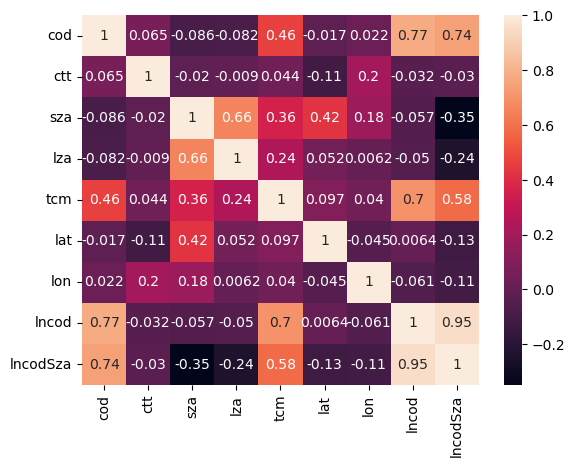

In [60]:
#correlatin matrix 
df2020_finalw0NoMonth = df2020_finalw0.drop(["month_January", "month_July", "month_March", "month_May", "month_September"], axis = 1)

corr_matrix = df2020_finalw0NoMonth.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [84]:
#linear regression with all variables except month 
smf.ols(formula='tcm ~ cod + ctt + sza + lza + lat + lon + pressure', data=df2020_finalw0).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tcm   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                 5.869e+05
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:24:52   Log-Likelihood:             4.5220e+06
No. Observations:             6487423   AIC:                        -9.044e+06
Df Residuals:                 6487415   BIC:                        -9.044e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3980      0.001   -724.224      0.000      -0.399      -0.397
cod            0.4573      0.000   1615.618      0.000       0.457       0.458
ctt            0.0005      0.000      2.304      0.021    7.27e-05       0.001
sza            0.7462      0.001    949.322      0.000       0.745       0.748
lza           -0.0464      0.001    -57.433      0.000      -0.048      -0.045
lat           -0.0397      0.000   -245.957      0.000      -0.040      -0.039
lon           -0.0214      0.000   -189.600      0.000      -0.022      -0.021
pressure       0.0163      0.000     56.146      0.000       0.016       0.017
==============================================================================
Omnibus:                    59117.280   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82943.571
Skew:                           0.119   Prob(JB):                         0.00
Kurtosis:                       3.500   Cond. No.                         40.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
#Model 1 Creation
model1X = df2020_finalw0[["cod", "ctt", "lza", "sza","lat", "lon", "pressure"]]
model1Y = df2020_finalw0[['tcm']]

model1 = LinearRegression().fit(model1X, model1Y)

In [86]:
#model1 scores 

print("R^2 = ", model1.score(model1X, model1Y))
      
model1pred = model1.predict(model1X)

print("MAE = ", metrics.mean_absolute_error(model1Y, model1pred))
print(f"The RMSE is {np.sqrt(metrics.mean_squared_error(model1Y, model1pred))}")

R^2 =  0.38771959051330696
MAE =  0.09368980177989202
The RMSE is 0.1205159793235058


In [87]:
#variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
X2 = df2020_final[['cod', 'ctt', 'sza','lza','lat', 'lon', 'pressure']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X2.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X2.values, i)
                          for i in range(len(X2.columns))]
  
print(vif_data)

    feature         VIF
0       cod    1.335306
1       ctt    7.015813
2       sza  187.066931
3       lza  195.720918
4       lat    1.365824
5       lon    2.454084
6  pressure   12.768667


In [88]:
#model 2: Transformed model by taking ln(cod) and adding interaction term ln(cod)*sza
smf.ols(formula='tcm ~ lncod + lncodSza + ctt + sza + lza + lat + lon + pressure', data=df2020_finalw0).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tcm   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.516e+06
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:42:38   Log-Likelihood:             7.5095e+06
No. Observations:             6487423   AIC:                        -1.502e+07
Df Residuals:                 6487414   BIC:                        -1.502e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1194      0.001  -1467.167      0.000      -1.121      -1.118
lncod         -0.2798      0.000  -1139.217      0.000      -0.280      -0.279
lncodSza       0.4511      0.000   1602.722      0.000       0.451       0.452
ctt            0.0338      0.000    253.924      0.000       0.034       0.034
sza            1.9489      0.001   2148.655      0.000       1.947       1.951
lza           -0.0014      0.001     -2.730      0.006      -0.002      -0.000
lat           -0.0272      0.000   -266.426      0.000      -0.027      -0.027
lon           -0.0027   7.12e-05    -37.523      0.000      -0.003      -0.003
pressure       0.0134      0.000     73.246      0.000       0.013       0.014
==============================================================================
Omnibus:                  3403737.199   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         63381111.791
Skew:                           2.110   Prob(JB):                         0.00
Kurtosis:                      17.720   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
#Model 2 Creation
model2X = df2020_finalw0[["lncod", "lncodSza", "ctt", "lza", "sza","lat", "lon"]]
model2Y = df2020_finalw0[['tcm']]

model2 = LinearRegression().fit(model2X, model2Y)

In [47]:
#Model2 Scores
print("R^2 = ", model2.score(model2X, model2Y))
      
model2pred = model2.predict(model2X)

print("MAE = ", metrics.mean_absolute_error(model2Y, model2pred))
print(f"The RMSE is {np.sqrt(metrics.mean_squared_error(model2Y, model2pred))}")

R^2 =  0.7529690947389671
MAE =  0.05035239554682341
The RMSE is 0.07638191292530815


In [48]:
#model3 -- final
smf.ols(formula='tcm ~ lncod + lncodSza + sza', data=df2020_finalw0).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    tcm   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                 6.170e+06
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:01:55   Log-Likelihood:             7.2999e+06
No. Observations:             6460205   AIC:                        -1.460e+07
Df Residuals:                 6460201   BIC:                        -1.460e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0532      0.001  -1387.442      0.000      -1.055      -1.052
lncod         -0.2790      0.000  -1108.024      0.000      -0.280      -0.279
lncodSza       0.4494      0.000   1557.145      0.000       0.449       0.450
sza            1.8967      0.001   2174.789      0.000       1.895       1.898
==============================================================================
Omnibus:                  3103499.041   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         51188539.012
Skew:                           1.908   Prob(JB):                         0.00
Kurtosis:                      16.252   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
#Model3 Creation 

model3X = df2020_finalw0[["lncod", "lncodSza", "sza"]]
model3Y = df2020_finalw0[['tcm']]

model3 = LinearRegression().fit(model3X, model3Y)

In [50]:
#model3 Scores 
print("R^2 = ", model3.score(model3X, model3Y))
      
model3pred = model3.predict(model3X)

print("MAE = ", metrics.mean_absolute_error(model3Y, model3pred))
print(f"The RMSE is {np.sqrt(metrics.mean_squared_error(model3Y, model3pred))}")


R^2 =  0.7412956648331219
MAE =  0.05177094277324786
The RMSE is 0.07816579313813998


In [51]:
#variance inflation factor


# the independent variables set
Xcov = df2020_finalw0[['sza', 'lncodSza']]
  
# VIF dataframe
vif_dataCov = pd.DataFrame()
vif_dataCov["feature"] = Xcov.columns
  
# calculating VIF for each feature
vif_dataCov["VIF"] = [variance_inflation_factor(Xcov.values, i)
                          for i in range(len(Xcov.columns))]
  
print(vif_dataCov)

    feature      VIF
0       sza  9.32179
1  lncodSza  9.32179


In [55]:
#splitting into training and test sets 
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(model3X, model3Y, test_size=0.25, random_state=42)

In [56]:
#model 3 performance on big dataset
model3.score(xTrain, yTrain)

0.7416633221512399

In [57]:
#model 3 cross validation 
from sklearn.model_selection import cross_validate

linear = LinearRegression()
cv_results = cross_validate(linear, X, Y, cv = 5)
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [58]:
#results of cross validation
cv_results['test_score'].mean()

0.7363213668849505

<AxesSubplot: ylabel='Density'>

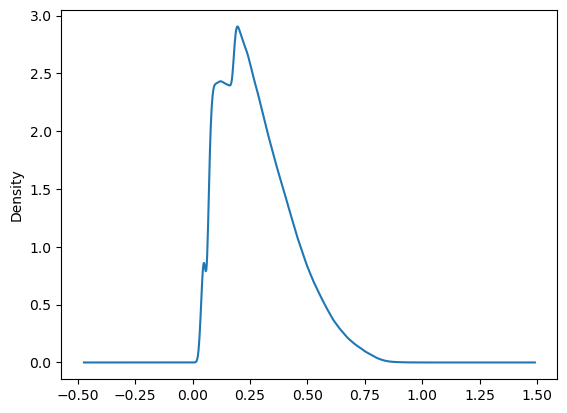

In [246]:
#distribution of the response ... training set (merged samples from 15 datasets in 2020) (TCM != 0)
df2020_finalwo0['tcm'].plot(kind='kde')

FOR NOW 05FEBNIGHT SKIP NEXT FEW LINES 

In [78]:
#function to get the tcm values and predictions and residuals

def predAndResid(dataset, model20201):
    df = testDayNS(dataset)
    print("dataset read in -- ready to predict")
    #uncomment to use model 2 (transformed model) variables 
    #Xtestvar = df[["lncod", "lncodSza", "ctt", "sza", "lza", "lat", "lon"]]
    #using model3
    Xtestvar = df[["lncod", "lncodSza", "sza"]]
    Ytestvar= df[['tcm']]
    
    #getting R^2, MAE, RMSE
    score = model20201.score(Xtestvar, Ytestvar) #be careful using global variables in a function... will want to change this later....
    print("The R^2 = ", score)
    predictions = model20201.predict(Xtestvar)
    print("MAE = ", metrics.mean_absolute_error(Ytestvar, predictions))
    print(f"The RMSE is {np.sqrt(metrics.mean_squared_error(Ytestvar, predictions))}")
    
    predDf = pd.DataFrame()
    
    indx = np.array(df.index.tolist())
    indx = indx.reshape(indx.shape[0], 1)
    
    predDf[["prediction"]] = predictions
    predDf[['indx']] = indx
    
    dfFull = fullSet(dataset)
    
    print("Full dataset created")
    
    dfHeatMap = dfFull.merge(predDf, how = "left", left_index = True, right_on = predDf["indx"])
    dfHeatMap.set_index('key_0')
    print("Predictions Filled")
    
    #getting the residuals 
    resid = np.subtract(dfHeatMap[['tcm']], dfHeatMap[['prediction']]).values
    print("Residuals created")
    tcmVal = dfHeatMap[['tcm']].values.reshape(10848,10848)
    print("TCM values obtained")
    tcmPred = dfHeatMap[['prediction']].values.reshape(10848,10848)
    resid = resid.reshape(10848, 10848)
    #absolute value of the residuals 
    residAbs = abs(resid)
    
    return tcmVal, tcmPred, residAbs, dfHeatMap

In [79]:
#tcmVal05MAY are the tcm values, tcmPred05May are the predictions, residAbs05May are the errors, and MAY05SET is the full dataset with all variables 
tcmVal05MAY, tcmPred05MAY, residAbs05MAY, MAY05set = predAndResid("05MAY2020.mat", model3)

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       sza       lza       tcm
5613886    0.032297  0.844235  0.712250  0.104399
5613887    0.033394  0.844209  0.712248  0.162390
5613888    0.036701  0.844183  0.712246  0.241560
5613889    0.041815  0.844158  0.712244  0.282406
5613994    0.045929  0.841269  0.711815  0.234501
...             ...       ...       ...       ...
112021689  0.023189  0.668167  0.712409  0.000000
112021690  0.023622  0.668149  0.712416  0.000000
112021691  0.023906  0.668130  0.712423  0.000000
112021692  0.024093  0.668112  0.712430  0.000000
112021693  0.024240  0.668094  0.712438  0.000000

[41646146 rows x 4 columns]
Shape of dataframe is  (41646146, 4)
NaN's dropped
Latitude and Longitude normalized
Dataset merged
dataset read in -- ready to predict
The R^2 =  0.715996118204197
MAE =  0.06153698248237125
The RMSE is 0.09093256765791796
<KeysViewHDF5 ['TCM',

/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
Full dataset created
Predictions Filled


/tmp/ipykernel_6318/2210002883.py:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  resid = np.subtract(dfHeatMap[['tcm']], dfHeatMap[['prediction']]).values


Residuals created
TCM values obtained


In [84]:
MAY05set["error"] = residAbs05MAY.reshape(-1)

In [85]:
MAY05set

,key_0,cod,ctt,sza,lza,tcm,prediction,indx,error
NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
NaN,117679099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,117679100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,117679101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,117679102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
#May 5th 2020 error by TCM threshold 
for i in np.arange(0, 1, .1):
    print(f'Threshold {i} - {i + .1}: {np.mean(MAY05set.loc[(MAY05set["tcm"] >= i) & (MAY05set["tcm"] <= i + .1) & (MAY05set["tcm"].isna() == False) & (MAY05set["error"].isna() == False)]["error"])}, count : {MAY05set.loc[(MAY05set["tcm"] >= i) & (MAY05set["tcm"] <= i + .1) & (MAY05set["tcm"].isna() == False) & (MAY05set["error"].isna() == False)].shape[0]}')

Threshold 0.0 - 0.1: 0.1005725894582386, count : 10829329
Threshold 0.1 - 0.2: 0.0384868967443088, count : 9610277
Threshold 0.2 - 0.30000000000000004: 0.03623746567165595, count : 8831458
Threshold 0.30000000000000004 - 0.4: 0.041589660180268946, count : 5657558
Threshold 0.4 - 0.5: 0.06115293102413218, count : 3647454
Threshold 0.5 - 0.6: 0.08912123034821502, count : 1907132
Threshold 0.6000000000000001 - 0.7000000000000001: 0.12715435778459427, count : 863804
Threshold 0.7000000000000001 - 0.8: 0.15018754517143085, count : 256859
Threshold 0.8 - 0.9: 0.1556825732828778, count : 40410
Threshold 0.9 - 1.0: 0.38934927644960243, count : 1865


In [131]:
#January 5th tcm values, predictions, errors, and total dataset 
tcmVal05JAN, tcmPred05JAN, residAbs05JAN, JAN05set = predAndResid("05JAN2020.mat", model3)

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       sza       lza       tcm
5613682    0.054933  0.814969  0.711796  0.217860
5613683    0.050100  0.815007  0.711803  0.216095
5613684    0.046787  0.815044  0.711809  0.233744
5613685    0.044644  0.815082  0.711815  0.227693
5613686    0.043324  0.815119  0.711821  0.212061
...             ...       ...       ...       ...
112065181  0.028402  0.670673  0.712157  0.198193
112065198  0.021760  0.671271  0.712207  0.256688
112065199  0.026587  0.671306  0.712210  0.238030
112065200  0.033017  0.671340  0.712212  0.300812
112065201  0.041196  0.671375  0.712215  0.337876

[40969575 rows x 4 columns]
Shape of dataframe is  (40969575, 4)
NaN's dropped
Latitude and Longitude normalized
Dataset merged
dataset read in -- ready to predict
The R^2 =  0.7071457203299629
MAE =  0.06858970738207296
The RMSE is 0.09760304450824678
<KeysViewHDF5 ['TCM'

/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
Full dataset created
Predictions Filled


/tmp/ipykernel_6318/2210002883.py:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  resid = np.subtract(dfHeatMap[['tcm']], dfHeatMap[['prediction']]).values


Residuals created
TCM values obtained


In [136]:
tcmVal05JAN2 = tcmVal05JAN
tcmVal05JAN2[tcmVal05JAN2 == 0] = np.nan

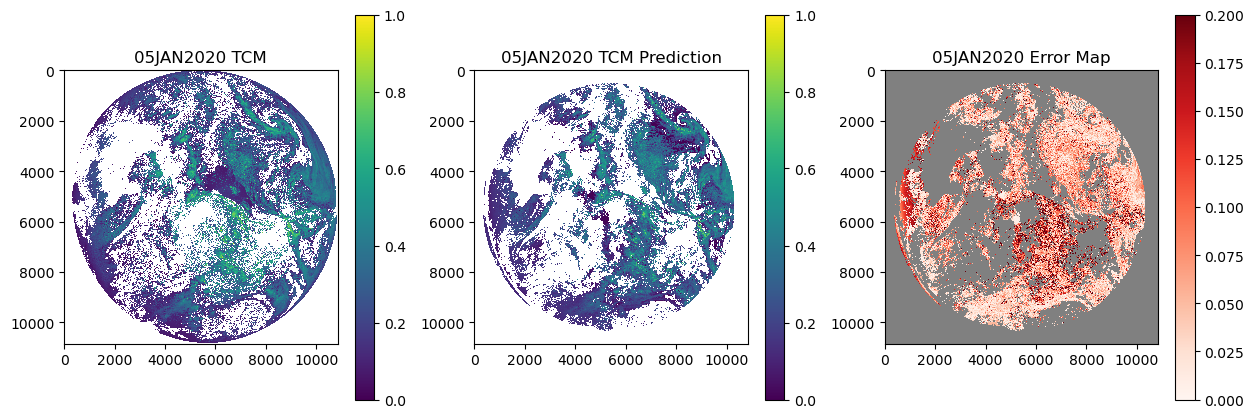

In [137]:
#creating TCM Truth map, Prediction map, and error map 
f2may, (ax3may, ax4may, ax2may) = plt.subplots(1,3, figsize = (15,5))
masked_array2may = np.ma.array(residAbs05JAN, mask=np.isnan(residAbs05JAN))
cmap2may = plt.cm.Reds
cmap2may.set_bad('grey',1.)
cac2may = ax2may.imshow(masked_array2may, interpolation='none', cmap=cmap2may, vmin = 0, vmax = .2)
ax2may.set_title("05JAN2020 Error Map")
f2may.colorbar(cac2may, ax=ax2may)

cac4may = ax4may.imshow(tcmPred05JAN, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax4may.set_title("05JAN2020 TCM Prediction")
f2may.colorbar(cac4may, ax=ax4may)

cac3may = ax3may.imshow(tcmVal05JAN2, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax3may.set_title("05JAN2020 TCM")
f2may.colorbar(cac3may, ax=ax3may)

In [139]:
JAN05set["error"] = residAbs05JAN.reshape(-1)

In [140]:
#January 5th error by TCM threshold 
for i in np.arange(0, 1, .1):
    print(f'Threshold {i} - {i + .1}: {np.mean(JAN05set.loc[(JAN05set["tcm"] >= i) & (JAN05set["tcm"] <= i + .1) & (JAN05set["tcm"].isna() == False) & (JAN05set["error"].isna() == False)]["error"])}, count : {JAN05set.loc[(JAN05set["tcm"] >= i) & (JAN05set["tcm"] <= i + .1) & (JAN05set["tcm"].isna() == False) & (JAN05set["error"].isna() == False)].shape[0]}')

Threshold 0.0 - 0.1: 0.102640806094514, count : 9848221
Threshold 0.1 - 0.2: 0.042055227369268186, count : 7797311
Threshold 0.2 - 0.30000000000000004: 0.04501362404389145, count : 8596976
Threshold 0.30000000000000004 - 0.4: 0.05086118119233065, count : 6451857
Threshold 0.4 - 0.5: 0.06420515752093907, count : 4361619
Threshold 0.5 - 0.6: 0.09635351452434471, count : 2364712
Threshold 0.6000000000000001 - 0.7000000000000001: 0.14415309899373357, count : 1160952
Threshold 0.7000000000000001 - 0.8: 0.19560848649628548, count : 335855
Threshold 0.8 - 0.9: 0.28119202765862683, count : 47879
Threshold 0.9 - 1.0: 0.43242581399042956, count : 4193


In [132]:
#March 5th 2020 tcm values, predictions, errors, and total dataset 
tcmVal05MAR, tcmPred05MAR, residAbs05MAR, MAR05set = predAndResid("05MAR2020.mat", model3)

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       sza       lza       tcm
5613806    0.034354  0.835509  0.712270  0.226432
5613807    0.037229  0.835519  0.712272  0.233492
5613808    0.040010  0.835528  0.712273  0.236518
5613809    0.042561  0.835538  0.712274  0.259462
5613810    0.044749  0.835547  0.712276  0.252402
...             ...       ...       ...       ...
112065417  0.027165  0.700061  0.711821  0.165668
112065418  0.027732  0.700064  0.711815  0.157600
112065419  0.026855  0.700067  0.711809  0.162894
112065420  0.025061  0.700070  0.711803  0.158860
112065421  0.022919  0.700073  0.711796  0.146758

[37267613 rows x 4 columns]
Shape of dataframe is  (37267613, 4)
NaN's dropped
Latitude and Longitude normalized
Dataset merged
dataset read in -- ready to predict
The R^2 =  0.6869917031666891
MAE =  0.06773052251398963
The RMSE is 0.10133979928009794
<KeysViewHDF5 ['TCM'

/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
Full dataset created
Predictions Filled


/tmp/ipykernel_6318/2210002883.py:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  resid = np.subtract(dfHeatMap[['tcm']], dfHeatMap[['prediction']]).values


Residuals created
TCM values obtained


In [141]:
tcmVal05MAR2 = tcmVal05MAR
tcmVal05MAR2[tcmVal05MAR2 == 0] = np.nan

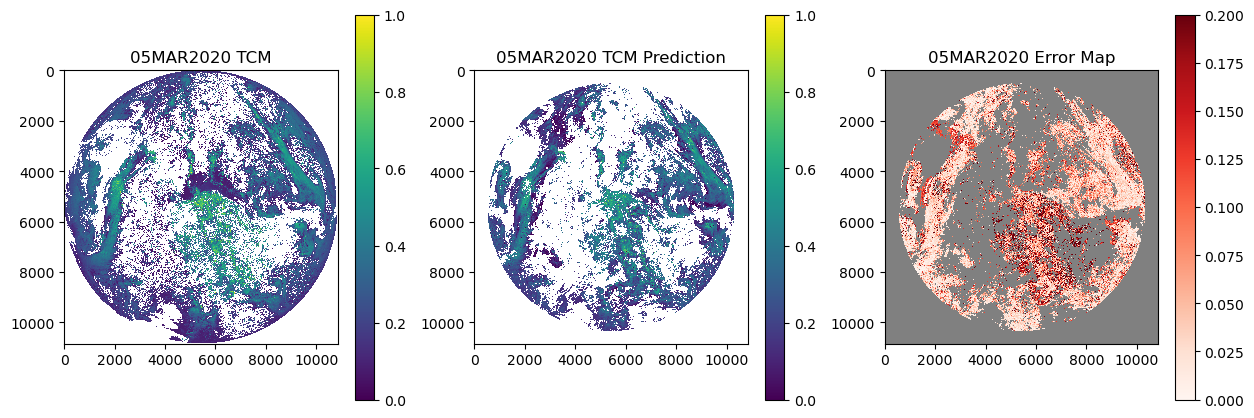

In [142]:
#March 5th 2020 TCM Truth Map, Prediction Map, and Error Map 
f2may, (ax3may, ax4may, ax2may) = plt.subplots(1,3, figsize = (15,5))
masked_array2may = np.ma.array(residAbs05MAR, mask=np.isnan(residAbs05MAR))
#cmap = plt.cm.jet
#cmap2may = plt.cm.binary
#cmap2may.set_bad('green',1.)
cmap2may = plt.cm.Reds
cmap2may.set_bad('grey',1.)
cac2may = ax2may.imshow(masked_array2may, interpolation='none', cmap=cmap2may, vmin = 0, vmax = .2)
ax2may.set_title("05MAR2020 Error Map")
f2may.colorbar(cac2may, ax=ax2may)

cac4may = ax4may.imshow(tcmPred05MAR, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax4may.set_title("05MAR2020 TCM Prediction")
f2may.colorbar(cac4may, ax=ax4may)

cac3may = ax3may.imshow(tcmVal05MAR2, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax3may.set_title("05MAR2020 TCM")
f2may.colorbar(cac3may, ax=ax3may)

In [143]:
MAR05set["error"] = residAbs05MAR.reshape(-1)

In [145]:
#March 5th error by TCM threshold 
for i in np.arange(0, 1, .1):
    print(f'Threshold {i} - {i + .1}: {np.mean(MAR05set.loc[(MAR05set["tcm"] >= i) & (MAR05set["tcm"] <= i + .1) & (MAR05set["tcm"].isna() == False) & (MAR05set["error"].isna() == False)]["error"])}, count : {MAR05set.loc[(MAR05set["tcm"] >= i) & (MAR05set["tcm"] <= i + .1) & (MAR05set["tcm"].isna() == False) & (MAR05set["error"].isna() == False)].shape[0]}')

Threshold 0.0 - 0.1: 0.10794505528666681, count : 7863025
Threshold 0.1 - 0.2: 0.04343314130696207, count : 6512532
Threshold 0.2 - 0.30000000000000004: 0.03961467370472114, count : 8237705
Threshold 0.30000000000000004 - 0.4: 0.0461564221619902, count : 6657022
Threshold 0.4 - 0.5: 0.06447022085562731, count : 4115662
Threshold 0.5 - 0.6: 0.0963244798519961, count : 2290833
Threshold 0.6000000000000001 - 0.7000000000000001: 0.14833611338851813, count : 1046197
Threshold 0.7000000000000001 - 0.8: 0.19963404017805478, count : 441414
Threshold 0.8 - 0.9: 0.2735401604074262, count : 93357
Threshold 0.9 - 1.0: 0.41296532558812543, count : 9866


In [133]:
#July 5th tcm values, predictions, errors, and total dataset 
tcmVal05JULY, tcmPred05JULY, residAbs05JULY, JULY05set = predAndResid("05JULY2020.mat", model3)

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       sza       lza       tcm
5613682    0.006230  0.825969  0.711796  0.000000
5613683    0.005922  0.825941  0.711803  0.000000
5613684    0.005648  0.825913  0.711809  0.000000
5613685    0.005407  0.825884  0.711815  0.000000
5613686    0.005201  0.825856  0.711821  0.000000
...             ...       ...       ...       ...
112065177  0.023132  0.675077  0.712143  0.360820
112065298  0.037094  0.671197  0.712269  0.000000
112065299  0.035153  0.671163  0.712268  0.000000
112065300  0.032281  0.671129  0.712266  0.000000
112065301  0.029361  0.671095  0.712265  0.098852

[38568686 rows x 4 columns]
Shape of dataframe is  (38568686, 4)
NaN's dropped
Latitude and Longitude normalized
Dataset merged
dataset read in -- ready to predict
The R^2 =  0.695649107062034
MAE =  0.06275381656589016
The RMSE is 0.09095956360381739
<KeysViewHDF5 ['TCM',

/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
Full dataset created
Predictions Filled


/tmp/ipykernel_6318/2210002883.py:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  resid = np.subtract(dfHeatMap[['tcm']], dfHeatMap[['prediction']]).values


Residuals created
TCM values obtained


In [146]:
tcmVal05JULY2 = tcmVal05JULY
tcmVal05JULY2[tcmVal05JULY2 == 0] = np.nan

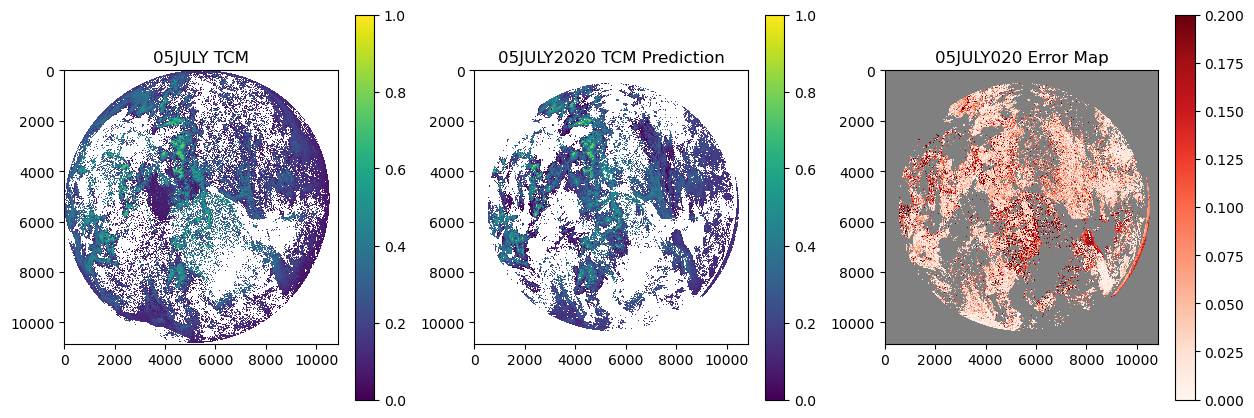

In [147]:
#July 5th TCM truth map, prediction map, and error map 
f2may, (ax3may, ax4may, ax2may) = plt.subplots(1,3, figsize = (15,5))
masked_array2may = np.ma.array(residAbs05JULY, mask=np.isnan(residAbs05JULY))
#cmap = plt.cm.jet
#cmap2may = plt.cm.binary
#cmap2may.set_bad('green',1.)
cmap2may = plt.cm.Reds
cmap2may.set_bad('grey',1.)
cac2may = ax2may.imshow(masked_array2may, interpolation='none', cmap=cmap2may, vmin = 0, vmax = .2)
ax2may.set_title("05JULY020 Error Map")
f2may.colorbar(cac2may, ax=ax2may)

cac4may = ax4may.imshow(tcmPred05JULY, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax4may.set_title("05JULY2020 TCM Prediction")
f2may.colorbar(cac4may, ax=ax4may)

cac3may = ax3may.imshow(tcmVal05JULY2, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax3may.set_title("05JULY TCM")
f2may.colorbar(cac3may, ax=ax3may)

In [148]:
JULY05set["error"] = residAbs05JULY.reshape(-1)

In [149]:
#July 5th error by TCM threshold 
for i in np.arange(0, 1, .1):
    print(f'Threshold {i} - {i + .1}: {np.mean(JULY05set.loc[(JULY05set["tcm"] >= i) & (JULY05set["tcm"] <= i + .1) & (JULY05set["tcm"].isna() == False) & (JULY05set["error"].isna() == False)]["error"])}, count : {JULY05set.loc[(JULY05set["tcm"] >= i) & (JULY05set["tcm"] <= i + .1) & (JULY05set["tcm"].isna() == False) & (JULY05set["error"].isna() == False)].shape[0]}')

Threshold 0.0 - 0.1: 0.09491423882279161, count : 11060021
Threshold 0.1 - 0.2: 0.041657653316762806, count : 9623919
Threshold 0.2 - 0.30000000000000004: 0.03987007019373505, count : 7954263
Threshold 0.30000000000000004 - 0.4: 0.04623897860802418, count : 4763125
Threshold 0.4 - 0.5: 0.06197713009789723, count : 2763610
Threshold 0.5 - 0.6: 0.08992581759535163, count : 1469480
Threshold 0.6000000000000001 - 0.7000000000000001: 0.13167614496570457, count : 678151
Threshold 0.7000000000000001 - 0.8: 0.14794414698814295, count : 237015
Threshold 0.8 - 0.9: 0.22763336363709058, count : 18147
Threshold 0.9 - 1.0: 0.3904403006452297, count : 955


In [134]:
#September 5th tcm values, predictions, errors, and total dataset
tcmVal05SEP, tcmPred05EP, residAbs05SEP, SEP05set = predAndResid("05SEP2020.mat", model3)

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       sza       lza       tcm
5613682    0.120239  0.856524  0.711796  0.296778
5613683    0.119256  0.856519  0.711803  0.295013
5613684    0.117648  0.856515  0.711809  0.294508
5613685    0.115396  0.856510  0.711815  0.292239
5613686    0.112463  0.856506  0.711821  0.287197
...             ...       ...       ...       ...
112065417  0.142608  0.671134  0.711821  0.164407
112065418  0.146532  0.671119  0.711815  0.164659
112065419  0.144404  0.671105  0.711809  0.164155
112065420  0.137981  0.671090  0.711803  0.164407
112065421  0.129132  0.671075  0.711796  0.163651

[38367682 rows x 4 columns]
Shape of dataframe is  (38367682, 4)
NaN's dropped
Latitude and Longitude normalized
Dataset merged
dataset read in -- ready to predict
The R^2 =  0.6705376998722007
MAE =  0.06782334101608312
The RMSE is 0.09754744305408872
<KeysViewHDF5 ['TCM'

/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
Full dataset created
Predictions Filled


/tmp/ipykernel_6318/2210002883.py:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  resid = np.subtract(dfHeatMap[['tcm']], dfHeatMap[['prediction']]).values


Residuals created
TCM values obtained


In [150]:
tcmVal05SEP2 = tcmVal05SEP
tcmVal05SEP2[tcmVal05SEP2 == 0] = np.nan

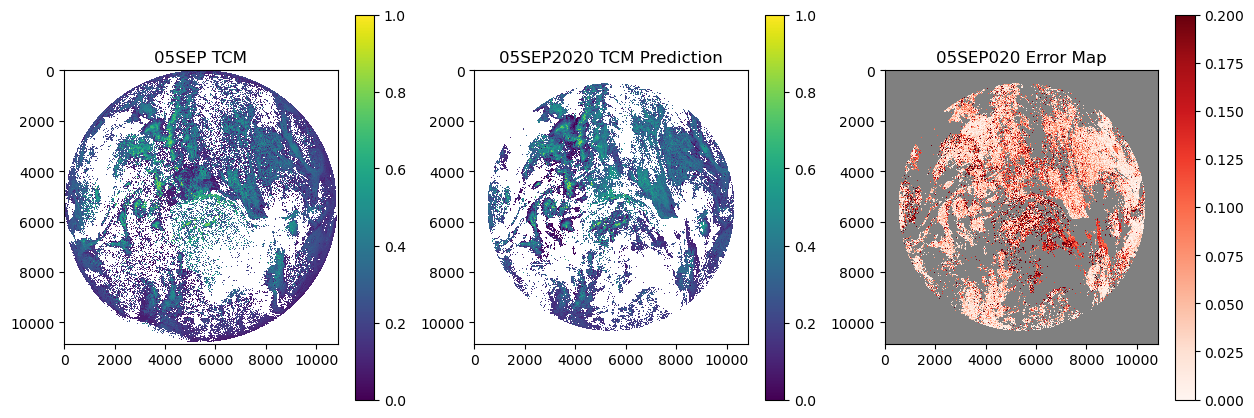

In [154]:
#September 5th 2020 truth tcm, prediction map, and error map 

f2may, (ax3may, ax4may, ax2may) = plt.subplots(1,3, figsize = (15,5))
masked_array2may = np.ma.array(residAbs05SEP, mask=np.isnan(residAbs05SEP))
#cmap = plt.cm.jet
#cmap2may = plt.cm.binary
#cmap2may.set_bad('green',1.)
cmap2may = plt.cm.Reds
cmap2may.set_bad('grey',1.)
cac2may = ax2may.imshow(masked_array2may, interpolation='none', cmap=cmap2may, vmin = 0, vmax = .2)
ax2may.set_title("05SEP020 Error Map")
f2may.colorbar(cac2may, ax=ax2may)

cac4may = ax4may.imshow(tcmPred05EP, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax4may.set_title("05SEP2020 TCM Prediction")
f2may.colorbar(cac4may, ax=ax4may)

cac3may = ax3may.imshow(tcmVal05SEP2, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax3may.set_title("05SEP TCM")
f2may.colorbar(cac3may, ax=ax3may)

In [151]:
SEP05set["error"] = residAbs05SEP.reshape(-1)

In [152]:
#September 5th error by TCM threshold

for i in np.arange(0, 1, .1):
    print(f'Threshold {i} - {i + .1}: {np.mean(SEP05set.loc[(SEP05set["tcm"] >= i) & (SEP05set["tcm"] <= i + .1) & (SEP05set["tcm"].isna() == False) & (SEP05set["error"].isna() == False)]["error"])}, count : {SEP05set.loc[(SEP05set["tcm"] >= i) & (SEP05set["tcm"] <= i + .1) & (SEP05set["tcm"].isna() == False) & (SEP05set["error"].isna() == False)].shape[0]}')

Threshold 0.0 - 0.1: 0.11541186607059703, count : 8300285
Threshold 0.1 - 0.2: 0.05369674749258829, count : 7410877
Threshold 0.2 - 0.30000000000000004: 0.04397902995026365, count : 9149667
Threshold 0.30000000000000004 - 0.4: 0.04488470752788012, count : 6703845
Threshold 0.4 - 0.5: 0.05980026487786768, count : 3863646
Threshold 0.5 - 0.6: 0.08418109528046717, count : 1779933
Threshold 0.6000000000000001 - 0.7000000000000001: 0.12851416024347984, count : 782118
Threshold 0.7000000000000001 - 0.8: 0.15772218131461246, count : 318780
Threshold 0.8 - 0.9: 0.18330644090077966, count : 54958
Threshold 0.9 - 1.0: 0.36092174701008833, count : 3573


In [173]:
#May 15th 2020 tcm values, predictions, errors, and total dataset 

tcmVal15MAY, tcmPred15MAY, residAbs15MAY, MAY15set = predAndResid("MAY152020new2.mat", model3)

<KeysViewHDF5 ['TCM', 'cod', 'ctt', 'lza', 'sza']>
Variables read in correctly
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)


/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
                cod       sza       lza       tcm
5613694    0.007251  0.844650  0.711869  0.084985
5613695    0.007048  0.844627  0.711875  0.075656
5613696    0.006802  0.844603  0.711881  0.000000
5613697    0.006624  0.844580  0.711886  0.000000
5613730    0.012141  0.843785  0.712053  0.108686
...             ...       ...       ...       ...
112065121  0.142466  0.664297  0.711886  0.165416
112065122  0.139081  0.664274  0.711892  0.168693
112065123  0.138798  0.664251  0.711898  0.151296
112065124  0.140157  0.664227  0.711903  0.151044
112065125  0.141641  0.664204  0.711909  0.154322

[37852117 rows x 4 columns]
Shape of dataframe is  (37852117, 4)
NaN's dropped
Latitude and Longitude normalized
Dataset merged
dataset read in -- ready to predict
The R^2 =  0.7032004445520794
MAE =  0.06378834273529572
The RMSE is 0.09347635412980178
<KeysViewHDF5 ['TCM'

/tmp/ipykernel_6318/1062666506.py:21: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  newImg = interp.zoom(input = img, zoom = factor, mode = pickMode, prefilter = False)


The new size of the image is (10848, 10848)
The new size of the image is (10848, 10848)
variables correctly sized
Variables correctly normalized
DataFrame correctly made
Full dataset created
Predictions Filled


/tmp/ipykernel_6318/2210002883.py:36: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  resid = np.subtract(dfHeatMap[['tcm']], dfHeatMap[['prediction']]).values


Residuals created
TCM values obtained


In [174]:
tcmVal15MAY2 = tcmVal15MAY
tcmVal15MAY2[tcmVal15MAY2 == 0] = np.nan

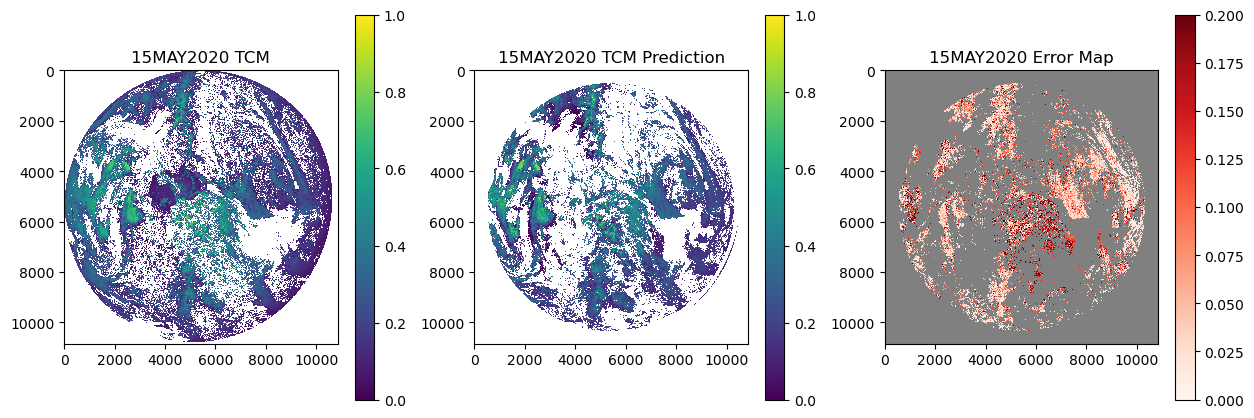

In [175]:
#May 15th truth tcm, prediction map, and error map 

f2may, (ax3may, ax4may, ax2may) = plt.subplots(1,3, figsize = (15,5))
masked_array2may = np.ma.array(residAbs15MAY, mask=np.isnan(residAbs15MAY))
#cmap = plt.cm.jet
#cmap2may = plt.cm.binary
#cmap2may.set_bad('green',1.)
cmap2may = plt.cm.Reds
cmap2may.set_bad('grey',1.)
cac2may = ax2may.imshow(masked_array2may, interpolation='none', cmap=cmap2may, vmin = 0, vmax = .2)
ax2may.set_title("15MAY2020 Error Map")
f2may.colorbar(cac2may, ax=ax2may)

cac4may = ax4may.imshow(tcmPred15MAY, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax4may.set_title("15MAY2020 TCM Prediction")
f2may.colorbar(cac4may, ax=ax4may)

cac3may = ax3may.imshow(tcmVal15MAY2, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax3may.set_title("15MAY2020 TCM")
f2may.colorbar(cac3may, ax=ax3may)

In [176]:
MAY15set["error"] = residAbs15MAY.reshape(-1)

In [178]:
#May 15th error by TCM threshold 

for i in np.arange(0, 1, .1):
    print(f'Threshold {i} - {i + .1}: {np.mean(MAY15set.loc[(MAY15set["tcm"] >= i) & (MAY15set["tcm"] <= i + .1) & (MAY15set["tcm"].isna() == False) & (MAY15set["error"].isna() == False)]["error"])}, count : {MAY15set.loc[(MAY15set["tcm"] >= i) & (MAY15set["tcm"] <= i + .1) & (MAY15set["tcm"].isna() == False) & (MAY15set["error"].isna() == False)].shape[0]}')

Threshold 0.0 - 0.1: 0.1062063197659933, count : 8952996
Threshold 0.1 - 0.2: 0.040913630003661085, count : 8379513
Threshold 0.2 - 0.30000000000000004: 0.039091255463434456, count : 8555250
Threshold 0.30000000000000004 - 0.4: 0.044200777639951574, count : 5521651
Threshold 0.4 - 0.5: 0.06087888875340618, count : 3287614
Threshold 0.5 - 0.6: 0.09158012652682333, count : 1952204
Threshold 0.6000000000000001 - 0.7000000000000001: 0.12794298670069235, count : 923352
Threshold 0.7000000000000001 - 0.8: 0.15295085612283676, count : 256697
Threshold 0.8 - 0.9: 0.2537719543145167, count : 21765
Threshold 0.9 - 1.0: 0.4417387049632455, count : 1075


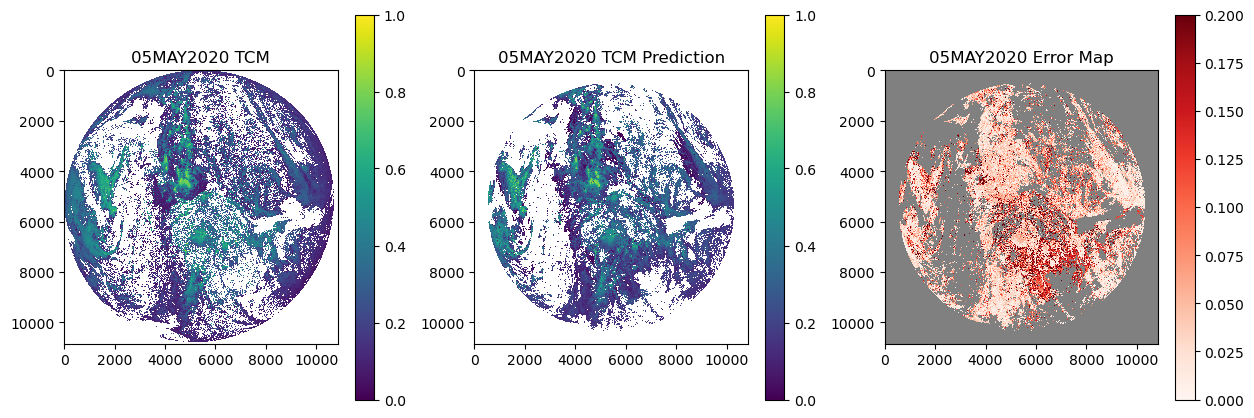

In [74]:
#May 5th 2020 tcm, prediction, and error map 
f2may, (ax3may, ax4may, ax2may) = plt.subplots(1,3, figsize = (15,5))
masked_array2may = np.ma.array(residAbs05MAY, mask=np.isnan(residAbs05MAY))
#cmap = plt.cm.jet
#cmap2may = plt.cm.binary
#cmap2may.set_bad('green',1.)
cmap2may = plt.cm.Reds
cmap2may.set_bad('grey',1.)
cac2may = ax2may.imshow(masked_array2may, interpolation='none', cmap=cmap2may, vmin = 0, vmax = .2)
ax2may.set_title("05MAY2020 Error Map")
f2may.colorbar(cac2may, ax=ax2may)

cac4may = ax4may.imshow(tcmPred05MAY, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax4may.set_title("05MAY2020 TCM Prediction")
f2may.colorbar(cac4may, ax=ax4may)

cac3may = ax3may.imshow(tcmVal05MAY, interpolation='none', vmin = 0, vmax = 1)  #could do interpolation none....
ax3may.set_title("05MAY2020 TCM")
f2may.colorbar(cac3may, ax=ax3may)